In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
import concurrent.futures
import pickle
warnings.filterwarnings('ignore', message='.*unary_union.*')

lodes = pd.read_csv("data/LODES.csv", low_memory=False)
census = pd.read_csv("data/Decennial_Census.csv")
shapes = gpd.read_file("data/tract_shapefiles/il_t_2020_bound.shp")

lodes["workplace_tract_code"] = lodes["workplace_block_code"].apply(lambda x: str(x)[:11])
lodes["home_tract_code"] = lodes["home_block_code"].apply(lambda x: str(x)[:11])

lodes.drop("Unnamed: 0", axis=1, inplace=True)
census.drop("Unnamed: 0", axis=1, inplace=True)
shapes = shapes[['STATEFP20', 'COUNTYFP20', 'TRACTCE20', 'GEOID20', 'geometry']]
shapes = shapes.to_crs(epsg=3435)
census["tract_code"] = census["geo_id"].apply(lambda x: x[-11:])
census["population"] = census["white"] + census["black"] + census["asian"] + census["american_indian_alaska_native"] + census["pacific_islander"] + census["other_race"] + census["multiracial"] + census["hispanic_latino"]

In [ ]:
import random
from shapely.geometry import Polygon
from shapely.ops import unary_union
import networkx as nx
import numpy as np
random.seed(42)
from concurrent.futures import ProcessPoolExecutor, as_completed
import copy
from copy import deepcopy
import os 
import time
from redistricting_utils import evaluate_proposal
from shapely.geometry import Point

class ILRedistricting:
    def __init__(self, census_df, shapes_df, lodes_df, n_districts=17):
        '''Initializes the redistricting object.'''
        self.census = census_df.copy()
        self.shapes = shapes_df.copy()
        self.lodes = lodes_df.copy()
        self.n_districts = n_districts

        self.data = self.census.merge(
            self.shapes[['GEOID20', 'geometry']], 
            left_on='tract_code', right_on='GEOID20', 
            how='left'
        ).drop(columns=['GEOID20'])
        
        self.data = gpd.GeoDataFrame(self.data, geometry='geometry')
        self.data.set_crs(epsg=3435, inplace=True)

        self.block_to_idx = dict(zip(self.data['tract_code'], range(len(self.data))))
        self.graph = self._create_block_graph()

    def _initialize_lodes_scores(self, districts):
        """
        Compute initial LODES scores for all districts from scratch.
        """
        print("Calculating initial LODES scores.")  # To make sure it's goten to here
        lodes_scores = {}
        for district_idx, district in enumerate(districts):  # Checking each district
            tracts = set(district)
            district_lodes = self.lodes[
                self.lodes['workplace_tract_code'].isin(tracts) |
                self.lodes['home_tract_code'].isin(tracts)
            ]

            total_live_in = district_lodes[district_lodes['home_tract_code'].isin(tracts)]['total_jobs'].sum()
            total_work_in = district_lodes[district_lodes['workplace_tract_code'].isin(tracts)]['total_jobs'].sum()
            live_and_work_in = district_lodes[
                (district_lodes['workplace_tract_code'].isin(tracts)) &
                (district_lodes['home_tract_code'].isin(tracts))
            ]['total_jobs'].sum()

            percentage_live_and_work = (live_and_work_in / total_live_in) * 100 if total_live_in > 0 else 0
            percentage_work_and_live = (live_and_work_in / total_work_in) * 100 if total_work_in > 0 else 0

            # District score is weighted towards those who live in a district working in that district - discussed in paper
            district_score = (2 / 3 * percentage_live_and_work) + (1 / 3 * percentage_work_and_live)
            lodes_scores[district_idx] = district_score / 100

        print("Initial LODES scores calculated.")
        return lodes_scores
    
    def _create_block_graph(self): # Uses the Fifeld et al. (2019) theory - defines the graph and initializes the nodes/edges. Discussed in paper + readme. 
        '''Creates graph of census tracts.'''
        graph = nx.Graph()
        for idx, row in self.data.iterrows():
            graph.add_node(row['tract_code'], geometry=row['geometry'])
        
        for idx, row in self.data.iterrows(): # Creating aforementioned edges
            possible_neighbors = self.data.sindex.query(row['geometry'], predicate='intersects')
            for neighbor_idx in possible_neighbors:
                if idx != neighbor_idx:
                    neighbor_geom = self.data.iloc[neighbor_idx]['geometry']
                    if row['geometry'].intersection(neighbor_geom).length > 0:
                        graph.add_edge(row['tract_code'], self.data.iloc[neighbor_idx]['tract_code'])
        return graph

    def _is_contiguous(self, district): # Contiguity check. Yes, I know this is being called too many times. Unless it's called every time I breathe, there will be an exception where a district loses 
        # contiguity, and the entire algorithm degenerates, so it really is necessary. 
        ''' Checks to ensure contiguity of a certain district. '''
        if not district: 
            return False
        subgraph = self.graph.subgraph(district)
        return nx.is_connected(subgraph)

    def _generate_proposal(self, districts, lodes_scores, max_attempts=10):
        for attempt in range(max_attempts): # Max attempts - mainly for edge cases, rarely ever see this happen. In 4-5 runs of 35,000 iterations have seen a handful of times where more than even 
            # just 3 attempts is necessary. Reason to cause new attempt - previous proposal violated contiguity. 
            print(f"Attempt {attempt + 1}/{max_attempts}: Generating proposal...")

            new_districts = [list(district) for district in districts]

            #choose a random district and tract within district
            from_district_idx = random.randint(0, len(new_districts) - 1)
            from_district = new_districts[from_district_idx]
            if not from_district:
                continue

            eligible_tracts = []
            for tract in from_district:
                neighbors = list(self.graph.neighbors(tract))
                external_neighbors = sum(
                    1 for neighbor in neighbors if any(neighbor in d for d in new_districts if d != from_district)
                )
                eligible_tracts.extend([tract] * (external_neighbors ** 2)) #weights tracts by number of out of district neighbors

            if not eligible_tracts: #check to prevent error from breaking algo
                continue
            tract_to_move = random.choice(eligible_tracts) #chooses random tract to move 

            if tract_to_move not in from_district:
                print(f"Error: tract_to_move {tract_to_move} not found in from_district_idx {from_district_idx}.") #check to prevent error from breaking algo
                continue

            neighbors = list(self.graph.neighbors(tract_to_move))
            neighboring_districts = [
                idx for idx, district in enumerate(new_districts)
                if any(neighbor in district for neighbor in neighbors) and idx != from_district_idx
            ]

            if not neighboring_districts:
                continue

            to_district_idx = random.choice(neighboring_districts)
            from_district.remove(tract_to_move)
            new_districts[to_district_idx].append(tract_to_move)

            #verify congruity
            if self._is_contiguous(new_districts[from_district_idx]) and self._is_contiguous(new_districts[to_district_idx]):
                if all(self._is_contiguous(district) for district in new_districts):
                    print(f"Attempt {attempt + 1}: Successfully generated a valid proposal.")
                    return new_districts, tract_to_move, from_district_idx, to_district_idx, lodes_scores

            #revert changes if it doesn't go well
            new_districts[to_district_idx].remove(tract_to_move)
            from_district.append(tract_to_move)

        print(f"Failed to generate a valid contiguous proposal after {max_attempts} attempts.")
        return None, None, None, None, None


    def _evaluate_proposal(self, proposal,lodes_scores=None, tract_to_move=None, from_district_idx=None, to_district_idx=None, weights=None):
        """
        Evaluate the proposal using normalized scores for each metric.
        Each score is normalized to approximately [0,1] range before weighting.
        
        Args:
            proposal: List of districts to evaluate
            lodes_scores: Pre-calculated LODES scores (optional)
            tract_to_move: Tract that was moved (optional, for incremental updates)
            from_district_idx: Source district index (optional, for incremental updates)
            to_district_idx: Target district index (optional, for incremental updates)
            weights: Dictionary of weights for each metric (optional)
        """
        print(f"Started evaluate_proposal at {time.time()}")

        #default weights if none provided are equal
        if weights is None:
            weights = {
                'compactness': 1.0,
                'community': 1.0,
                'population': 1.0,
                'vra': 1.0
            }

        district_centers = []
        compactness_scores = []

        scaling_factor_exp_distance = 0.75
        scaling_factor_distance = 0.00001

        for district in proposal:
            district_data = self.data[self.data['tract_code'].isin(district)]
            total_population = district_data['population'].sum()
            district_area = district_data.geometry.area.sum()

            if total_population == 0 or district_data.empty:
                compactness_scores.append(0)
                continue

            district_data = district_data.copy()
            district_data['centroid'] = district_data.geometry.centroid

            x_center = np.average(district_data['centroid'].x, weights=district_data['population'])
            y_center = np.average(district_data['centroid'].y, weights=district_data['population'])
            center = Point(x_center, y_center)

            distances = district_data['centroid'].apply(lambda g: g.distance(center))
            mean_squared_distance = np.mean(distances**2) * scaling_factor_distance

            expected_distance = scaling_factor_exp_distance * (district_area ** 0.5)
            lower_bound = 0.1 * expected_distance
            upper_bound = 3.0 * expected_distance

            if mean_squared_distance <= lower_bound:
                compactness_score = 1
            elif mean_squared_distance >= upper_bound:
                compactness_score = 0
            else:
                compactness_score = 1 - (mean_squared_distance - lower_bound) / (upper_bound - lower_bound)

            compactness_scores.append(compactness_score)

            #print(f"District Compactness: {compactness_score:.4f}, "
            #    f"Unweighted Mean Squared Distance: {mean_squared_distance:.2f}, "
            #    f"Expected Distance: {expected_distance:.2f}, "
            #    f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")

        #harmonic mean to overpenalize lower scores
        compactness_score = len(compactness_scores) / sum(1 / score for score in compactness_scores if score > 0)


        #LODES using the aforementioned incremental evaluator
        if tract_to_move is not None and from_district_idx is not None and to_district_idx is not None:
            print("Performing incremental LODES update.")
            lodes_scores = self._evaluate_proposal_incremental(
                proposal, tract_to_move, from_district_idx, to_district_idx, lodes_scores
            )
        elif lodes_scores is None:
            raise ValueError("LODES scores must not be None during the initial evaluation.")
        
        community_score = np.mean(list(lodes_scores.values()))
        print(f"Community Preservation recalculated: {community_score:.4f}")

        # Population parity score SECTION BELOW:
        district_populations = np.array([
            self.data[self.data['tract_code'].isin(district)]['population'].sum()
            for district in proposal
        ])
        target_population = district_populations.mean()

        quartic_deviations = ((district_populations - target_population) ** 4).sum()

        population_score = 1 - min(quartic_deviations / self.max_possible_quartic, 1)

        #VRA compliance
        district_hispanic_pop = [
            self.data[self.data['tract_code'].isin(district)]['hispanic_latino'].sum() 
            for district in proposal
        ]
        district_black_pop = [
            self.data[self.data['tract_code'].isin(district)]['black'].sum() 
            for district in proposal
        ]
        
        hispanic_percentages = [h / t for h, t in zip(district_hispanic_pop, district_populations)]
        black_percentages = [b / t for b, t in zip(district_black_pop, district_populations)]
        
        target_majority_districts = 2  # Target number of majority-minority districts
        hispanic_majority = sum(1 for pct in hispanic_percentages if pct > 0.5)
        black_majority = sum(1 for pct in black_percentages if pct > 0.5)
        
        vra_score = (min(hispanic_majority, target_majority_districts) + 
                    min(black_majority, target_majority_districts)) / (2 * target_majority_districts)

        #given provided weights
        total_score = (
            weights['compactness'] * compactness_score +
            weights['community'] * community_score +
            weights['population'] * population_score +
            weights['vra'] * vra_score
        ) / sum(weights.values())  #normalize by sum of weights

        print(
            f"Compactness: {compactness_score:.4f}, "
            f"Community Preservation: {community_score:.4f}, "
            f"Population Parity: {population_score:.4f}, "
            f"VRA Score: {vra_score:.4f}, "
            f"Total Score: {total_score:.4f}"
        )

        return total_score, compactness_score, community_score, population_score, vra_score
    
    def _evaluate_proposal_incremental(self, proposal, tract_to_move, from_district_idx, to_district_idx, previous_scores):
        """
        Incrementally update the LODES scores for the affected districts.
        """
        if previous_scores is None:
            raise ValueError("previous_scores must not be None for incremental updates.")

        print(f"Updating LODES scores for districts {from_district_idx} and {to_district_idx}.")

        #create copy of scores
        current_scores = deepcopy(previous_scores)

        #update the from index
        from_district_tracts = set(proposal[from_district_idx])
        district_lodes = self.lodes[
            self.lodes['workplace_tract_code'].isin(from_district_tracts) |
            self.lodes['home_tract_code'].isin(from_district_tracts)
        ]
        total_live_in = district_lodes[district_lodes['home_tract_code'].isin(from_district_tracts)]['total_jobs'].sum()
        total_work_in = district_lodes[district_lodes['workplace_tract_code'].isin(from_district_tracts)]['total_jobs'].sum()
        live_and_work_in = district_lodes[
            (district_lodes['workplace_tract_code'].isin(from_district_tracts)) &
            (district_lodes['home_tract_code'].isin(from_district_tracts))
        ]['total_jobs'].sum()

        percentage_live_and_work = (live_and_work_in / total_live_in) * 100 if total_live_in > 0 else 0
        percentage_work_and_live = (live_and_work_in / total_work_in) * 100 if total_work_in > 0 else 0
        current_scores[from_district_idx] = (2 / 3 * percentage_live_and_work + 1 / 3 * percentage_work_and_live) / 100

        #update the to index
        to_district_tracts = set(proposal[to_district_idx])
        district_lodes = self.lodes[
            self.lodes['workplace_tract_code'].isin(to_district_tracts) |
            self.lodes['home_tract_code'].isin(to_district_tracts)
        ]
        total_live_in = district_lodes[district_lodes['home_tract_code'].isin(to_district_tracts)]['total_jobs'].sum()
        total_work_in = district_lodes[district_lodes['workplace_tract_code'].isin(to_district_tracts)]['total_jobs'].sum()
        live_and_work_in = district_lodes[
            (district_lodes['workplace_tract_code'].isin(to_district_tracts)) &
            (district_lodes['home_tract_code'].isin(to_district_tracts))
        ]['total_jobs'].sum()

        percentage_live_and_work = (live_and_work_in / total_live_in) * 100 if total_live_in > 0 else 0
        percentage_work_and_live = (live_and_work_in / total_work_in) * 100 if total_work_in > 0 else 0
        current_scores[to_district_idx] = (2 / 3 * percentage_live_and_work + 1 / 3 * percentage_work_and_live) / 100

        return current_scores

    def _initialize_random_districts(self):
        """
        Generate initial districts that are guaranteed to be contiguous using a flood-fill approach.
        Ensures no districts fall below 20% of the target population.
        Handles contiguity issues incrementally instead of restarting.
        This is one of those functions that you think is going to be extremely trivial to implement.  You realize something is wrong. You change/fix it. 
        Something else is wrong. You change it. Something else is wrong. Before you know it, you've got a Frankenstein monster of a function. 
        """
        while True:
            total_population = self.data['population'].sum()
            target_population = total_population / self.n_districts

            unassigned_blocks = set(self.data['tract_code'])
            block_populations = dict(zip(self.data['tract_code'], self.data['population']))
            districts = [[] for _ in range(self.n_districts)]
            district_populations = [0] * self.n_districts

            for district_idx in range(self.n_districts):
                if not unassigned_blocks:
                    break

                seed_block = random.choice(list(unassigned_blocks))
                queue = [seed_block]

                while queue:
                    block = queue.pop(0)

                    if block not in unassigned_blocks:
                        continue
                    if district_populations[district_idx] + block_populations[block] > target_population * 1.1:
                        continue

                    districts[district_idx].append(block)
                    district_populations[district_idx] += block_populations[block]
                    unassigned_blocks.remove(block)

                    neighbors = list(self.graph.neighbors(block))
                    for neighbor in neighbors:
                        if neighbor in unassigned_blocks:
                            queue.append(neighbor)

            for block in unassigned_blocks:
                best_district = None
                max_neighbors = -1

                neighbors = list(self.graph.neighbors(block))
                for district_idx, district in enumerate(districts):
                    neighbor_count = sum(1 for neighbor in neighbors if neighbor in district)
                    if neighbor_count > max_neighbors:
                        max_neighbors = neighbor_count
                        best_district = district_idx

                if best_district is not None:
                    districts[best_district].append(block)
                    district_populations[best_district] += block_populations[block]
                else:
                    min_population_idx = district_populations.index(min(district_populations))
                    districts[min_population_idx].append(block)
                    district_populations[min_population_idx] += block_populations[block]

            underpopulated_threshold = 0.2 * target_population
            donor_threshold = 0.4 * target_population
            attempts = {}

            for idx, district in enumerate(districts):
                while district_populations[idx] < underpopulated_threshold:
                    print(f"District {idx} has population below 20% of target. Redistributing neighbors.")

                    neighbors = set(
                        neighbor for block in district
                        for neighbor in self.graph.neighbors(block)
                    )
                    if idx not in attempts:
                        attempts[idx] = set()

                    transferred = False
                    for neighbor in neighbors:
                        if neighbor in attempts[idx]:
                            continue

                        donor_idx = next(
                            (i for i, d in enumerate(districts) if neighbor in d), None
                        )
                        if donor_idx is not None and donor_idx != idx and district_populations[donor_idx] > donor_threshold:
                            districts[donor_idx].remove(neighbor)
                            districts[idx].append(neighbor)
                            district_populations[donor_idx] -= block_populations[neighbor]
                            district_populations[idx] += block_populations[neighbor]

                            if self._is_contiguous(districts[district_idx]) and self._is_contiguous(districts[donor_idx]):
                                transferred = True
                                print(f"Transferred block {neighbor} from District {donor_idx} to District {idx}.")
                                break
                            else:
                                districts[idx].remove(neighbor)
                                districts[donor_idx].append(neighbor)
                                district_populations[donor_idx] += block_populations[neighbor]
                                district_populations[idx] -= block_populations[neighbor]
                                attempts[idx].add(neighbor)

                    if not transferred:
                        print(f"Warning: Unable to fully populate district {idx}. Moving to next district.")
                        break

            if all(self._is_contiguous(district) for district in districts):
                return districts
            else:
                print("Contiguity issues detected in final validation. Restarting generation...")

    def mcmc(self, phase1_iterations=10000, phase2_iterations=15000, phase3_iterations=10000):
        """
        Three-phase MCMC optimization:
        Phase 1: Focus on population parity and basic compactness
        Phase 2: Focus on community preservation and VRA compliance
        Phase 3: Final legality check with balanced priorities
        """
        districts = self._initialize_random_districts()
        districts_initial = deepcopy(districts)
        total_iterations = phase1_iterations + phase2_iterations + phase3_iterations
        
        #start logging scores
        scores_log = {
            "iteration": [],
            "phase": [],
            "total_score": [],
            "compactness": [],
            "community_preservation": [],
            "population_parity": [],
            "vra_score": [],
            "temperature": [],
        }
        initial_district_populations = np.array([
            self.data[self.data['tract_code'].isin(district)]['population'].sum()
            for district in districts
        ])
        initial_target_population = initial_district_populations.mean()
        initial_quartic_deviations = ((initial_district_populations - initial_target_population) ** 4).sum()

        #defined max possible deviations
        self.max_possible_quartic = 1.25 * initial_quartic_deviations

        #calc initial LODES score
        lodes_scores = self._initialize_lodes_scores(districts)
        
        current_iteration = 0
        
        def get_weights(iteration):
            """
            Determine weights based on current phase and iteration
            Returns dict of weights for each scoring component
            """
            if iteration < phase1_iterations:  #this is for phase 1
                return {
                    'compactness': 1.0,
                    'community': 0.0,
                    'population': 2.0,  #population parity is what we really care about here
                    'vra': 1.0
                }
            elif iteration < (phase1_iterations + phase2_iterations):  #phase 2
                return {
                    'compactness': 1.0,
                    'community': 3.0,  #high weight for community preservation
                    'population': 0.5,  #maintain reasonable population balance
                    'vra': 1.5        #increased focus on VRA compliance
                }
            else:  #this is for phase 3
                return {
                    'compactness': 1.5,  #restored for compliance
                    'community': 0.5,
                    'population': 3.0,  #legal compliance
                    'vra': 1.5        #legal compliance
                }
        
        def get_temperature(iteration):
            """
            Dynamic temperature schedule that resets at each phase transition
            """
            if iteration < phase1_iterations:
                progress = iteration / phase1_iterations
                T_initial_1, T_final_1 = 0.00002, 0.000002 #we want this temperature to be the lowest, as we want to, for sure have good population and compactness
                return T_initial_1 * ((T_final_1 / T_initial_1) ** progress)
            
            elif iteration < (phase1_iterations + phase2_iterations):
                progress = (iteration - phase1_iterations) / phase2_iterations
                T_initial_2, T_final_2 = 0.0001, 0.00001  #higher temperature for evolution 
                return T_initial_2 * ((T_final_2 / T_initial_2) ** progress)
            
            else:
                progress = (iteration - (phase1_iterations + phase2_iterations)) / phase3_iterations
                T_initial_3, T_final_3 = 0.00005, 0.000005  #lower for final refinement
                return T_initial_3 * ((T_final_3 / T_initial_3) ** progress)
        
        best_districts = deepcopy(districts)
        current_score, _, _, _, _ = self._evaluate_proposal(districts, lodes_scores, weights = get_weights(1))
        best_score = current_score

        for iteration in range(total_iterations):
            print(f"Iteration {iteration}: Phase {1 if iteration < phase1_iterations else 2 if iteration < phase1_iterations + phase2_iterations else 3}")

            if iteration == phase1_iterations or iteration == (phase1_iterations + phase2_iterations):
                print(f"Transitioning to Phase {2 if iteration == phase1_iterations else 3}")

                print(f"Old Current Score: {current_score:.4f} before Phase Transition")

                #update weights for the new phase
                current_weights = get_weights(iteration)
                
                #recalculate the current score using the new phase weights
                current_score, _, _, _, _ = self._evaluate_proposal(districts, lodes_scores, weights=current_weights)
                
                #reset best_score and best_districts to current score and districts
                best_score = current_score
                best_districts = deepcopy(districts)
                print(f"Updated Current Score: {best_score:.4f} after Phase Transition")

            new_districts, tract_to_move, from_district_idx, to_district_idx, _ = self._generate_proposal(districts, lodes_scores)
            
            if new_districts is None:
                print(f"Iteration {iteration}: Proposal generation failed. Skipping.")
                continue
            
            lodes_scores = self._evaluate_proposal_incremental(
                new_districts, tract_to_move, from_district_idx, to_district_idx, lodes_scores
            )
            
            current_weights = get_weights(iteration)
            new_score, compactness, community_preservation, population_parity, vra_score = self._evaluate_proposal(
                new_districts, lodes_scores, weights=current_weights
            )
            
            T = get_temperature(iteration)
            
            current_phase = 1 if iteration < phase1_iterations else 2 if iteration < phase1_iterations + phase2_iterations else 3
            scores_log["iteration"].append(iteration)
            scores_log["phase"].append(current_phase)
            scores_log["total_score"].append(new_score)
            scores_log["compactness"].append(compactness)
            scores_log["community_preservation"].append(community_preservation)
            scores_log["population_parity"].append(population_parity)
            scores_log["vra_score"].append(vra_score)
            scores_log["temperature"].append(T)
            
            if new_score > best_score:
                best_districts = deepcopy(new_districts)
                best_score = new_score
                print(f"Iteration {iteration}: New best score {best_score:.4f}")
            
            diff = new_score - current_score
            likelihood = np.exp(diff / T)
            print(f"Score difference: {diff:.6f}, Temperature: {T:.6f}, Likelihood: {likelihood:.6f}")

            if new_score > current_score or random.uniform(0, 1) < np.exp((new_score - current_score) / T):
                districts = new_districts
                print(f"Before update: Current Score = {current_score}, New Score = {new_score}")
                current_score = new_score 
                print(f"After update: Current Score = {current_score}")
                print("Proposal accepted. Likelihood of random selection:", np.exp((new_score - current_score) / T))
            
            if iteration == phase1_iterations - 1:
                print("Transitioning to Phase 2: Community and VRA focus")
            elif iteration == phase1_iterations + phase2_iterations - 1:
                print("Transitioning to Phase 3: Legal compliance focus")

        
        return best_districts, districts_initial, scores_log


In [9]:
il_redistricting = ILRedistricting(census, shapes, lodes, n_districts=17)

In [10]:
optimal_districts, districtsinitial, scores_log = il_redistricting.mcmc(
        phase1_iterations=1000,
        phase2_iterations=1000,
        phase3_iterations=1500
    )

District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019001000 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019011002 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019000402 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019000200 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019005300 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019000302 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing neighbors.
Transferred block 17019000500 from District 7 to District 8.
District 8 has population below 20% of target. Redistributing 

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459357.717265
Community Preservation recalculated: 0.4203
Compactness: 0.7724, Community Preservation: 0.4203, Population Parity: 0.3548, VRA Score: 0.0000, Total Score: 0.3705
Score difference: -0.000114, Temperature: 0.000012, Likelihood: 0.000066
Iteration 229: Phase 1
Attempt 1/10: Generating proposal...
Attempt 2/10: Generating proposal...
Attempt 2: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 14.
Started evaluate_proposal at 1733459358.695694
Community Preservation recalculated: 0.4200
Compactness: 0.7726, Community Preservation: 0.4200, Population Parity: 0.3549, VRA Score: 0.0000, Total Score: 0.3706
Iteration 229: New best score 0.3706
Score difference: 0.000012, Temperature: 0.000012, Likelihood: 2.764272
Before update: Current Score = 0.3706150327208233, New Score = 0.37062703478301073
After update: Current Score = 0.37062703478301073
Proposal accepted. Likelihood of random selection: 1.0
Iteration 230:

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459409.645956
Community Preservation recalculated: 0.4210
Compactness: 0.7748, Community Preservation: 0.4210, Population Parity: 0.4169, VRA Score: 0.0000, Total Score: 0.4021
Iteration 291: New best score 0.4021
Score difference: 0.007803, Temperature: 0.000010, Likelihood: inf
Before update: Current Score = 0.39434032028276855, New Score = 0.4021437000121066
After update: Current Score = 0.4021437000121066
Proposal accepted. Likelihood of random selection: 1.0
Iteration 292: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 6.


/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459410.5507572
Community Preservation recalculated: 0.4211
Compactness: 0.7748, Community Preservation: 0.4211, Population Parity: 0.4170, VRA Score: 0.0000, Total Score: 0.4022
Iteration 292: New best score 0.4022
Score difference: 0.000037, Temperature: 0.000010, Likelihood: 35.980962
Before update: Current Score = 0.4021437000121066, New Score = 0.4021802826979674
After update: Current Score = 0.4021802826979674
Proposal accepted. Likelihood of random selection: 1.0
Iteration 293: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 11 and 1.
Started evaluate_proposal at 1733459411.183365
Community Preservation recalculated: 0.4211
Compactness: 0.7747, Community Preservation: 0.4211, Population Parity: 0.4169, VRA Score: 0.0000, Total Score: 0.4021
Score difference: -0.000064, Temperature: 0.000010, Likelihood: 0.001887
Iteration 294: Phase 1
Attempt 1/10: Generating prop

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459437.6145222
Community Preservation recalculated: 0.4211
Compactness: 0.7756, Community Preservation: 0.4211, Population Parity: 0.4345, VRA Score: 0.0000, Total Score: 0.4111
Score difference: -0.000013, Temperature: 0.000009, Likelihood: 0.242378
Iteration 328: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 13 and 0.
Started evaluate_proposal at 1733459438.2704651
Community Preservation recalculated: 0.4211
Compactness: 0.7756, Community Preservation: 0.4211, Population Parity: 0.4344, VRA Score: 0.0000, Total Score: 0.4111
Score difference: -0.000044, Temperature: 0.000009, Likelihood: 0.009585
Iteration 329: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 8 and 10.
Started evaluate_proposal at 1733459439.107882
Community Preservation recalculated: 0.4212
Compactness: 0.7755, Comm

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459559.144674
Community Preservation recalculated: 0.4230
Compactness: 0.7788, Community Preservation: 0.4230, Population Parity: 0.5143, VRA Score: 0.0000, Total Score: 0.4518
Score difference: -0.000008, Temperature: 0.000007, Likelihood: 0.318732
Before update: Current Score = 0.4518364552636116, New Score = 0.45182879524788166
After update: Current Score = 0.45182879524788166
Proposal accepted. Likelihood of random selection: 1.0
Iteration 476: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 2 and 4.
Started evaluate_proposal at 1733459559.8985522
Community Preservation recalculated: 0.4230
Compactness: 0.7788, Community Preservation: 0.4230, Population Parity: 0.5142, VRA Score: 0.0000, Total Score: 0.4518
Score difference: -0.000026, Temperature: 0.000007, Likelihood: 0.020345
Iteration 477: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully gene

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459583.4272482
Community Preservation recalculated: 0.4236
Compactness: 0.7783, Community Preservation: 0.4236, Population Parity: 0.5328, VRA Score: 0.0000, Total Score: 0.4610
Score difference: -0.000015, Temperature: 0.000006, Likelihood: 0.088071
Iteration 504: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 5 and 4.
Started evaluate_proposal at 1733459584.390948
Community Preservation recalculated: 0.4236
Compactness: 0.7782, Community Preservation: 0.4236, Population Parity: 0.5329, VRA Score: 0.0000, Total Score: 0.4610
Score difference: -0.000003, Temperature: 0.000006, Likelihood: 0.591391
Iteration 505: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 0 and 13.
Started evaluate_proposal at 1733459585.0471191
Community Preservation recalculated: 0.4237
Compactness: 0.7782, Commu

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459595.903012
Community Preservation recalculated: 0.4232
Compactness: 0.7791, Community Preservation: 0.4232, Population Parity: 0.5418, VRA Score: 0.0000, Total Score: 0.4657
Iteration 519: New best score 0.4657
Score difference: 0.000008, Temperature: 0.000006, Likelihood: 3.959717
Before update: Current Score = 0.465648691650669, New Score = 0.4656570227604351
After update: Current Score = 0.4656570227604351
Proposal accepted. Likelihood of random selection: 1.0
Iteration 520: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 4 and 2.
Started evaluate_proposal at 1733459596.646125
Community Preservation recalculated: 0.4231
Compactness: 0.7791, Community Preservation: 0.4231, Population Parity: 0.5418, VRA Score: 0.0000, Total Score: 0.4657
Iteration 520: New best score 0.4657
Score difference: 0.000005, Temperature: 0.000006, Likelihood: 2.359839
Before update: Curre

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459648.862004
Community Preservation recalculated: 0.4241
Compactness: 0.7802, Community Preservation: 0.4241, Population Parity: 0.5738, VRA Score: 0.0000, Total Score: 0.4820
Score difference: -0.000004, Temperature: 0.000005, Likelihood: 0.426275
Before update: Current Score = 0.48198081835773754, New Score = 0.4819763739819467
After update: Current Score = 0.4819763739819467
Proposal accepted. Likelihood of random selection: 1.0
Iteration 585: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 8 and 11.
Started evaluate_proposal at 1733459649.571388
Community Preservation recalculated: 0.4244
Compactness: 0.7811, Community Preservation: 0.4244, Population Parity: 0.5740, VRA Score: 0.0000, Total Score: 0.4823
Iteration 585: New best score 0.4823
Score difference: 0.000277, Temperature: 0.000005, Likelihood: 134146558623059741245440.000000
Before update: Current Score =

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459655.3428721
Community Preservation recalculated: 0.4245
Compactness: 0.7815, Community Preservation: 0.4245, Population Parity: 0.5847, VRA Score: 0.0000, Total Score: 0.4877
Iteration 592: New best score 0.4877
Score difference: 0.000110, Temperature: 0.000005, Likelihood: 2021119736.606645
Before update: Current Score = 0.4876078777976022, New Score = 0.48771752301513444
After update: Current Score = 0.48771752301513444
Proposal accepted. Likelihood of random selection: 1.0
Iteration 593: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 4 and 2.
Started evaluate_proposal at 1733459656.077787
Community Preservation recalculated: 0.4245
Compactness: 0.7815, Community Preservation: 0.4245, Population Parity: 0.5847, VRA Score: 0.0000, Total Score: 0.4877
Score difference: -0.000003, Temperature: 0.000005, Likelihood: 0.554711
Before update: Current Score = 0.4877175230

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459664.46737
Community Preservation recalculated: 0.4240
Compactness: 0.7820, Community Preservation: 0.4240, Population Parity: 0.5936, VRA Score: 0.0000, Total Score: 0.4923
Score difference: -0.000012, Temperature: 0.000005, Likelihood: 0.092103
Iteration 604: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 12 and 9.
Started evaluate_proposal at 1733459665.3178308
Community Preservation recalculated: 0.4240
Compactness: 0.7821, Community Preservation: 0.4240, Population Parity: 0.5855, VRA Score: 0.0000, Total Score: 0.4883
Score difference: -0.004057, Temperature: 0.000005, Likelihood: 0.000000
Iteration 605: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 14.
Started evaluate_proposal at 1733459666.260553
Community Preservation recalculated: 0.4236
Compactness: 0.7821, Commu

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459690.6892622
Community Preservation recalculated: 0.4233
Compactness: 0.7818, Community Preservation: 0.4233, Population Parity: 0.6112, VRA Score: 0.0000, Total Score: 0.5011
Iteration 635: New best score 0.5011
Score difference: 0.000100, Temperature: 0.000005, Likelihood: 2574106021.093983
Before update: Current Score = 0.5009624232782761, New Score = 0.5010628534529687
After update: Current Score = 0.5010628534529687
Proposal accepted. Likelihood of random selection: 1.0
Iteration 636: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 9 and 3.
Started evaluate_proposal at 1733459691.707546
Community Preservation recalculated: 0.4236
Compactness: 0.7818, Community Preservation: 0.4236, Population Parity: 0.6112, VRA Score: 0.0000, Total Score: 0.5010
Score difference: -0.000013, Temperature: 0.000005, Likelihood: 0.055582
Before update: Current Score = 0.501062853452

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459710.0862741
Community Preservation recalculated: 0.4243
Compactness: 0.7825, Community Preservation: 0.4243, Population Parity: 0.6179, VRA Score: 0.0000, Total Score: 0.5046
Iteration 659: New best score 0.5046
Score difference: 0.000023, Temperature: 0.000004, Likelihood: 185.570302
Before update: Current Score = 0.5045335190172253, New Score = 0.504556426960042
After update: Current Score = 0.504556426960042
Proposal accepted. Likelihood of random selection: 1.0
Iteration 660: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 14.
Started evaluate_proposal at 1733459711.065961
Community Preservation recalculated: 0.4243
Compactness: 0.7825, Community Preservation: 0.4243, Population Parity: 0.6179, VRA Score: 0.0000, Total Score: 0.5045
Score difference: -0.000007, Temperature: 0.000004, Likelihood: 0.221538
Iteration 661: Phase 1
Attempt 1/10: Generating prop

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459739.825129
Community Preservation recalculated: 0.4238
Compactness: 0.7840, Community Preservation: 0.4238, Population Parity: 0.6302, VRA Score: 0.0000, Total Score: 0.5111
Score difference: -0.000001, Temperature: 0.000004, Likelihood: 0.808764
Before update: Current Score = 0.5111326075944018, New Score = 0.5111317508061837
After update: Current Score = 0.5111317508061837
Proposal accepted. Likelihood of random selection: 1.0
Iteration 696: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 3 and 14.
Started evaluate_proposal at 1733459740.932518
Community Preservation recalculated: 0.4238
Compactness: 0.7841, Community Preservation: 0.4238, Population Parity: 0.6302, VRA Score: 0.0000, Total Score: 0.5111
Score difference: -0.000022, Temperature: 0.000004, Likelihood: 0.003949
Iteration 697: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully genera

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459763.5782819
Community Preservation recalculated: 0.4242
Compactness: 0.7842, Community Preservation: 0.4242, Population Parity: 0.6452, VRA Score: 0.0000, Total Score: 0.5187
Score difference: -0.000326, Temperature: 0.000004, Likelihood: 0.000000
Iteration 724: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 7 and 16.
Started evaluate_proposal at 1733459764.15621
Community Preservation recalculated: 0.4240
Compactness: 0.7850, Community Preservation: 0.4240, Population Parity: 0.6559, VRA Score: 0.0000, Total Score: 0.5242
Iteration 724: New best score 0.5242
Score difference: 0.005226, Temperature: 0.000004, Likelihood: inf
Before update: Current Score = 0.518993884624269, New Score = 0.5242194849986963
After update: Current Score = 0.5242194849986963
Proposal accepted. Likelihood of random selection: 1.0
Iteration 725: Phase 1
Attempt 1/10: Generating proposal...


/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459764.784533
Community Preservation recalculated: 0.4241
Compactness: 0.7844, Community Preservation: 0.4241, Population Parity: 0.6559, VRA Score: 0.0000, Total Score: 0.5241
Score difference: -0.000136, Temperature: 0.000004, Likelihood: 0.000000
Iteration 726: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 11 and 1.
Started evaluate_proposal at 1733459765.408097
Community Preservation recalculated: 0.4240
Compactness: 0.7846, Community Preservation: 0.4240, Population Parity: 0.6559, VRA Score: 0.0000, Total Score: 0.5241
Score difference: -0.000108, Temperature: 0.000004, Likelihood: 0.000000
Iteration 727: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 5 and 3.
Started evaluate_proposal at 1733459766.4979358
Community Preservation recalculated: 0.4237
Compactness: 0.7849, Commun

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459816.611733
Community Preservation recalculated: 0.4240
Compactness: 0.7857, Community Preservation: 0.4240, Population Parity: 0.6734, VRA Score: 0.0000, Total Score: 0.5331
Score difference: -0.000013, Temperature: 0.000003, Likelihood: 0.021374
Iteration 790: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 2 and 13.
Started evaluate_proposal at 1733459817.328938
Community Preservation recalculated: 0.4241
Compactness: 0.7858, Community Preservation: 0.4241, Population Parity: 0.6734, VRA Score: 0.0000, Total Score: 0.5331
Score difference: -0.000006, Temperature: 0.000003, Likelihood: 0.180598
Iteration 791: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 6 and 15.
Started evaluate_proposal at 1733459818.1677282
Community Preservation recalculated: 0.4241
Compactness: 0.7858, Commu

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459820.478274
Community Preservation recalculated: 0.4242
Compactness: 0.7859, Community Preservation: 0.4242, Population Parity: 0.6882, VRA Score: 0.0000, Total Score: 0.5406
Iteration 794: New best score 0.5406
Score difference: 0.000037, Temperature: 0.000003, Likelihood: 87368.939096
Before update: Current Score = 0.540555973464884, New Score = 0.5405925406829353
After update: Current Score = 0.5405925406829353
Proposal accepted. Likelihood of random selection: 1.0
Iteration 795: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 14.
Started evaluate_proposal at 1733459821.3945768
Community Preservation recalculated: 0.4241
Compactness: 0.7859, Community Preservation: 0.4241, Population Parity: 0.6882, VRA Score: 0.0000, Total Score: 0.5406
Iteration 795: New best score 0.5406
Score difference: 0.000000, Temperature: 0.000003, Likelihood: 1.039044
Before update

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459833.1175191
Community Preservation recalculated: 0.4252
Compactness: 0.7865, Community Preservation: 0.4252, Population Parity: 0.6861, VRA Score: 0.0000, Total Score: 0.5397
Score difference: -0.004499, Temperature: 0.000003, Likelihood: 0.000000
Iteration 810: Phase 1
Attempt 1/10: Generating proposal...
Attempt 2/10: Generating proposal...
Attempt 2: Successfully generated a valid proposal.
Updating LODES scores for districts 5 and 2.
Started evaluate_proposal at 1733459834.073863
Community Preservation recalculated: 0.4250
Compactness: 0.7865, Community Preservation: 0.4250, Population Parity: 0.6951, VRA Score: 0.0000, Total Score: 0.5442
Score difference: -0.000012, Temperature: 0.000003, Likelihood: 0.018835
Iteration 811: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 5 and 4.
Started evaluate_proposal at 1733459834.974968
Community Preservation recalculated

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459846.930835
Community Preservation recalculated: 0.4254
Compactness: 0.7872, Community Preservation: 0.4254, Population Parity: 0.7059, VRA Score: 0.0000, Total Score: 0.5498
Score difference: -0.000094, Temperature: 0.000003, Likelihood: 0.000000
Iteration 827: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 0.
Started evaluate_proposal at 1733459847.6057038
Community Preservation recalculated: 0.4253
Compactness: 0.7873, Community Preservation: 0.4253, Population Parity: 0.7060, VRA Score: 0.0000, Total Score: 0.5499
Score difference: -0.000008, Temperature: 0.000003, Likelihood: 0.076406
Iteration 828: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 13 and 2.
Started evaluate_proposal at 1733459848.336938
Community Preservation recalculated: 0.4253
Compactness: 0.7873, Commu

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459907.0222652
Community Preservation recalculated: 0.4242
Compactness: 0.7901, Community Preservation: 0.4242, Population Parity: 0.7235, VRA Score: 0.0000, Total Score: 0.5592
Iteration 902: New best score 0.5592
Score difference: 0.000067, Temperature: 0.000003, Likelihood: 409090517458.350464
Before update: Current Score = 0.5591775053463416, New Score = 0.5592445163245077
After update: Current Score = 0.5592445163245077
Proposal accepted. Likelihood of random selection: 1.0
Iteration 903: Phase 1
Attempt 1/10: Generating proposal...
Attempt 2/10: Generating proposal...
Attempt 2: Successfully generated a valid proposal.
Updating LODES scores for districts 10 and 7.
Started evaluate_proposal at 1733459907.9350069
Community Preservation recalculated: 0.4244
Compactness: 0.7897, Community Preservation: 0.4244, Population Parity: 0.7233, VRA Score: 0.0000, Total Score: 0.5591
Score difference: -0.000162, Temperature: 0.000003, Likelihood: 0.000000
Iter

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459916.346925
Community Preservation recalculated: 0.4251
Compactness: 0.7901, Community Preservation: 0.4251, Population Parity: 0.7281, VRA Score: 0.0000, Total Score: 0.5616
Score difference: -0.001951, Temperature: 0.000002, Likelihood: 0.000000
Iteration 914: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 8 and 1.
Started evaluate_proposal at 1733459917.0609632
Community Preservation recalculated: 0.4251
Compactness: 0.7899, Community Preservation: 0.4251, Population Parity: 0.7321, VRA Score: 0.0000, Total Score: 0.5635
Score difference: -0.000021, Temperature: 0.000002, Likelihood: 0.000193
Iteration 915: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 10 and 1.
Started evaluate_proposal at 1733459917.929089
Community Preservation recalculated: 0.4251
Compactness: 0.7902, Commun

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459921.158937
Community Preservation recalculated: 0.4249
Compactness: 0.7896, Community Preservation: 0.4249, Population Parity: 0.7356, VRA Score: 0.0000, Total Score: 0.5652
Score difference: -0.000169, Temperature: 0.000002, Likelihood: 0.000000
Iteration 920: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 14 and 8.
Started evaluate_proposal at 1733459922.145104
Community Preservation recalculated: 0.4249
Compactness: 0.7895, Community Preservation: 0.4249, Population Parity: 0.7356, VRA Score: 0.0000, Total Score: 0.5652
Score difference: -0.000174, Temperature: 0.000002, Likelihood: 0.000000
Iteration 921: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 9 and 2.
Started evaluate_proposal at 1733459923.061138
Community Preservation recalculated: 0.4245
Compactness: 0.7900, Communi

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459938.7418811
Community Preservation recalculated: 0.4251
Compactness: 0.7900, Community Preservation: 0.4251, Population Parity: 0.7481, VRA Score: 0.0000, Total Score: 0.5716
Iteration 940: New best score 0.5716
Score difference: 0.002851, Temperature: 0.000002, Likelihood: inf
Before update: Current Score = 0.5687027718407787, New Score = 0.5715535855103981
After update: Current Score = 0.5715535855103981
Proposal accepted. Likelihood of random selection: 1.0
Iteration 941: Phase 1
Attempt 1/10: Generating proposal...
Attempt 2/10: Generating proposal...
Attempt 2: Successfully generated a valid proposal.
Updating LODES scores for districts 0 and 13.


/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459939.4397042
Community Preservation recalculated: 0.4252
Compactness: 0.7900, Community Preservation: 0.4252, Population Parity: 0.7481, VRA Score: 0.0000, Total Score: 0.5716
Score difference: -0.000000, Temperature: 0.000002, Likelihood: 0.872945
Before update: Current Score = 0.5715535855103981, New Score = 0.5715532741992344
After update: Current Score = 0.5715532741992344
Proposal accepted. Likelihood of random selection: 1.0
Iteration 942: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 14.
Started evaluate_proposal at 1733459940.407716
Community Preservation recalculated: 0.4252
Compactness: 0.7900, Community Preservation: 0.4252, Population Parity: 0.7481, VRA Score: 0.0000, Total Score: 0.5716
Score difference: -0.000000, Temperature: 0.000002, Likelihood: 0.990137
Before update: Current Score = 0.5715532741992344, New Score = 0.5715532515433371
After 

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459943.33934
Community Preservation recalculated: 0.4247
Compactness: 0.7898, Community Preservation: 0.4247, Population Parity: 0.7576, VRA Score: 0.0000, Total Score: 0.5763
Iteration 946: New best score 0.5763
Score difference: 0.000008, Temperature: 0.000002, Likelihood: 31.030687
Before update: Current Score = 0.5762730964097326, New Score = 0.5762808759472596
After update: Current Score = 0.5762808759472596
Proposal accepted. Likelihood of random selection: 1.0
Iteration 947: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 12 and 9.
Started evaluate_proposal at 1733459944.262381
Community Preservation recalculated: 0.4251
Compactness: 0.7898, Community Preservation: 0.4251, Population Parity: 0.7561, VRA Score: 0.0000, Total Score: 0.5755
Score difference: -0.000786, Temperature: 0.000002, Likelihood: 0.000000
Iteration 948: Phase 1
Attempt 1/10: Generating propos

/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1093014990.py:568: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(diff / T)


Started evaluate_proposal at 1733459960.077135
Community Preservation recalculated: 0.4253
Compactness: 0.7902, Community Preservation: 0.4253, Population Parity: 0.7691, VRA Score: 0.0000, Total Score: 0.5821
Score difference: -0.000018, Temperature: 0.000002, Likelihood: 0.000249
Iteration 968: Phase 1
Attempt 1/10: Generating proposal...
Attempt 1: Successfully generated a valid proposal.
Updating LODES scores for districts 5 and 2.
Started evaluate_proposal at 1733459961.015436
Community Preservation recalculated: 0.4254
Compactness: 0.7902, Community Preservation: 0.4254, Population Parity: 0.7691, VRA Score: 0.0000, Total Score: 0.5821
Score difference: -0.000001, Temperature: 0.000002, Likelihood: 0.503739
Iteration 969: Phase 1
Attempt 1/10: Generating proposal...
Attempt 2/10: Generating proposal...
Attempt 2: Successfully generated a valid proposal.
Updating LODES scores for districts 15 and 0.
Started evaluate_proposal at 1733459961.688801
Community Preservation recalculated

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_scores(scores_log):
    scores_df = pd.DataFrame(scores_log)
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 20))
    
    #all scores over time
    scores_df.plot(
        x='iteration',
        y=['total_score', 'compactness', 'community_preservation', 
           'population_parity', 'vra_score'],
        ax=axes[0]
    )
    axes[0].set_title('Score Components Over Time')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Score')
    axes[0].axvline(x=10000, color='r', linestyle='--', label='Phase 1 End')
    axes[0].axvline(x=25000, color='g', linestyle='--', label='Phase 2 End')
    axes[0].legend()
    
    axes[1].plot(scores_df['iteration'], scores_df['temperature'])
    axes[1].set_title('Temperature Schedule')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Temperature')
    axes[1].set_yscale('log')
    
    sns.scatterplot(
        data=scores_df,
        x='compactness',
        y='community_preservation',
        hue='phase',
        ax=axes[2],
        alpha=0.5
    )
    axes[2].set_title('Compactness vs Community Preservation by Phase')
    
    plt.tight_layout()
    plt.show()

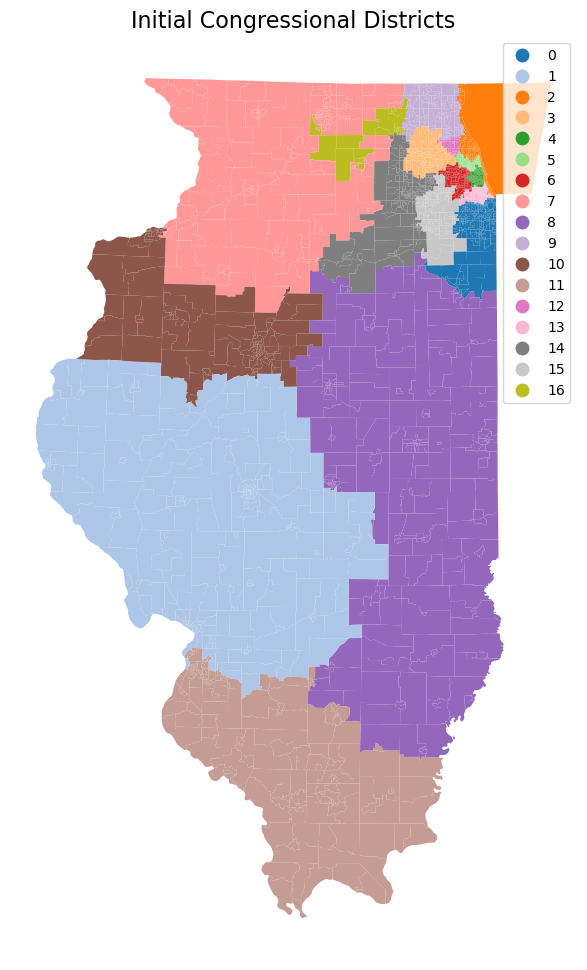

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(districtsinitial):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Initial Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


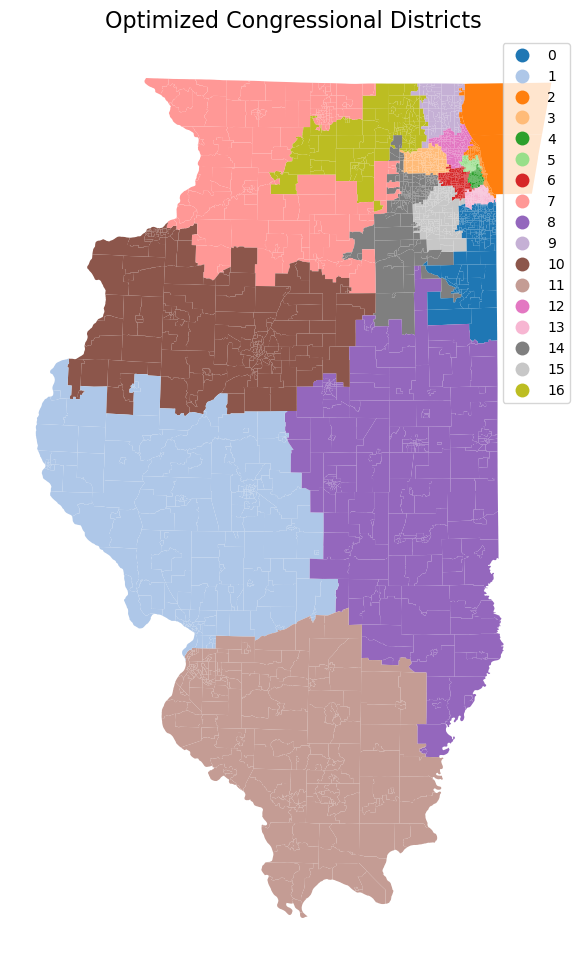

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(optimal_districts):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

cmap = mcolors.ListedColormap(plt.cm.tab20.colors[:17])

fig, ax = plt.subplots(figsize=(12, 12))
il_redistricting.data.plot(
    column='district', 
    cmap=cmap, 
    legend=True, 
    categorical=True, 
    ax=ax
)

ax.set_title("Optimized Congressional Districts", fontsize=16)
ax.set_axis_off()

plt.show()


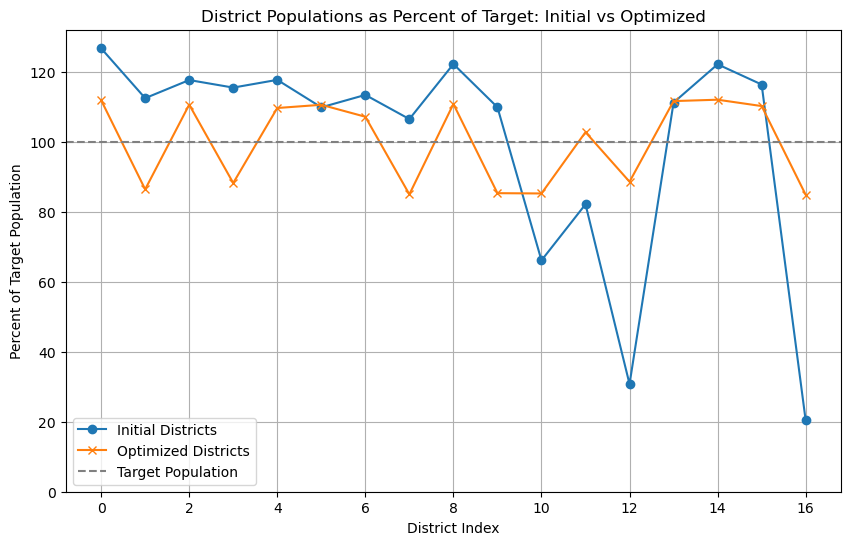

In [ ]:
import matplotlib.pyplot as plt

def calculate_population_percentages(districts, data, target_population):
    return [
        (sum(data[data['tract_code'].isin(district)]['population']) / target_population) * 100
        for district in districts
    ]

target_population = il_redistricting.data['population'].sum() / il_redistricting.n_districts

initial_percentages = calculate_population_percentages(districtsinitial, il_redistricting.data, target_population)
optimized_percentages = calculate_population_percentages(optimal_districts, il_redistricting.data, target_population)

plt.figure(figsize=(10, 6))
plt.plot(initial_percentages, label="Initial Districts", marker='o')
plt.plot(optimized_percentages, label="Optimized Districts", marker='x')
plt.axhline(
    100, 
    color='gray', linestyle='--', label="Target Population"
)

plt.title("District Populations as Percent of Target: Initial vs Optimized")
plt.xlabel("District Index")
plt.ylabel("Percent of Target Population")
plt.ylim(0, None) 
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#exporting everything as a ZIP

import shutil

output_directory = "output/onehour"
shapefile_base = "onehouronehour"

zip_file_name = f"{shapefile_base}.zip"

files_to_zip = [
    f"{output_directory}/{shapefile_base}.shp",
    f"{output_directory}/{shapefile_base}.shx",
    f"{output_directory}/{shapefile_base}.dbf",
    f"{output_directory}/{shapefile_base}.prj",
]

shutil.make_archive(shapefile_base, 'zip', output_directory)

print(f"Shapefile archived to {zip_file_name}")

Shapefile archived to onehouronehour.zip


In [ ]:
print(il_redistricting.data.head().columns)

Index(['geo_id', 'area_name', 'total_houses', 'occupied_houses',
       'vacant_houses', 'hispanic_latino', 'white', 'black', 'asian',
       'american_indian_alaska_native', 'pacific_islander', 'other_race',
       'multiracial', 'total_institutionalized', 'prison_pop',
       'juvenile_detention_pop', 'nursing_home_pop', 'college_dorm_pop',
       'military_housing_pop', 'other_group_quarters_pop', 'tract_code',
       'population', 'geometry', 'district'],
      dtype='object')


In [ ]:
#Exporting as a shapefile

il_redistricting.data['district'] = -1  
for district_number, district in enumerate(optimal_districts):
    il_redistricting.data.loc[
        il_redistricting.data['tract_code'].isin(district), 'district'
    ] = district_number

output_path = "output/onehour.shp"
il_redistricting.data.to_file(output_path, driver="ESRI Shapefile")

print(f"Shapefile with optimized districts saved to: {output_path}")


Shapefile with optimized districts saved to: output/onehour.shp


/var/folders/sp/g_s7ldrd28zcjypz0jlzcmhw0000gn/T/ipykernel_46577/1166854645.py:10: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  il_redistricting.data.to_file(output_path, driver="ESRI Shapefile")
/Users/ababu/miniconda3/envs/m1_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'total_houses' to 'total_hous'
  ogr_write(
/Users/ababu/miniconda3/envs/m1_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'occupied_houses' to 'occupied_h'
  ogr_write(
/Users/ababu/miniconda3/envs/m1_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'vacant_houses' to 'vacant_hou'
  ogr_write(
/Users/ababu/miniconda3/envs/m1_env/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'hispanic_latino' to 'hispanic_l'
  ogr_write(
/Users/ababu/miniconda3/envs

In [19]:
il_redistricting.data[['tract_code', 'district']].to_csv("district_info.csv", index=False)

In [20]:
df = pd.read_csv("district_info.csv")

# Convert 'tract_code' to string
df['tract_code'] = df['tract_code'].astype(str)

# Save back to CSV
df.to_csv("district_info_fixed.csv", index=False)

In [21]:
optimal_districts

[['17031827300',
  '17031826902',
  '17031827100',
  '17031827200',
  '17031827400',
  '17031827500',
  '17031824800',
  '17031826901',
  '17031827000',
  '17031826301',
  '17031826500',
  '17031827801',
  '17031824900',
  '17031825600',
  '17031827600',
  '17031828401',
  '17031827700',
  '17031828402',
  '17031828300',
  '17031827805',
  '17031824300',
  '17031824702',
  '17031826800',
  '17031826700',
  '17031826303',
  '17031826402',
  '17031540101',
  '17031826401',
  '17031826600',
  '17031827804',
  '17031827802',
  '17031825200',
  '17031825000',
  '17031825501',
  '17031825503',
  '17031828601',
  '17031828701',
  '17031828602',
  '17031828201',
  '17031828202',
  '17031828702',
  '17031827901',
  '17031823603',
  '17031824701',
  '17031824400',
  '17031821300',
  '17031821500',
  '17031826201',
  '17031826304',
  '17031825801',
  '17031550200',
  '17031540102',
  '17031825302',
  '17031824505',
  '17031824507',
  '17031824602',
  '17031825400',
  '17031825504',
  '17031825505